## read me

This file can process both resting state data and event related potentials. For the second, it's important that the data has event markers created with the script in the bitbrain importing section. 

Set variable **erp** to true or false to determine if you want to process event related potentials (True) or resting state data (false)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import autoreject
from tqdm import tqdm 
from atpbar import atpbar
from datetime import datetime
import mne
from autoreject import AutoReject
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

from pyprep.find_noisy_channels import NoisyChannels
from mne_icalabel import label_components


In [28]:
sub=0
paths = glob.glob(f"epochs/sub{sub}*")
paths.sort()
epochs_list = [mne.read_epochs(path) for path in paths]
epochs = mne.concatenate_epochs(epochs_list)

Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0_post_baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0_post_early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0_post_late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Readi

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3105983081.py:5: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_list)


In [52]:
sub=1
paths = glob.glob(f"epochs/sub{sub}*")
paths.sort()
epochs_list = [mne.read_epochs(path) for path in paths]
epochs = mne.concatenate_epochs(epochs_list)

evokeds_pre = dict(
    pre_baselin_h = list(epochs["-1"].iter_evoked()),
    pre_early_h = list(epochs["-2"].iter_evoked()),
    pre_late_h = list(epochs["-3"].iter_evoked()),
    
    pre_baselin_v = list(epochs["1"].iter_evoked()),
    pre_early_v = list(epochs["2"].iter_evoked()),
    pre_late_v = list(epochs["3"].iter_evoked()),
)


evokeds_post = dict(
    post_baselin_h = list(epochs["-4"].iter_evoked()),
    post_early_h = list(epochs["-5"].iter_evoked()),
    post_late_h = list(epochs["-6"].iter_evoked()),

    post_baselin_v = list(epochs["4"].iter_evoked()),
    post_early_v = list(epochs["5"].iter_evoked()),
    post_late_v = list(epochs["6"].iter_evoked()),
)



mne.viz.plot_compare_evokeds(evokeds_pre, combine="mean", picks='Oz', title="pre")
#plt.savefig(f'plots/{export_name}')
#plt.close()

mne.viz.plot_compare_evokeds(evokeds_post, combine="mean", picks='Oz', title="post")

Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub1_post_baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub1_post_early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub1_post_late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Readi

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/1938699680.py:5: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_list)


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/1938699680.py:30: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds_pre, combine="mean", picks='Oz', title="pre")


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/1938699680.py:34: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds_post, combine="mean", picks='Oz', title="post")


[<Figure size 1600x1200 with 2 Axes>]

In [41]:

epochs['1']

<EpochsArray |  120 events (all good), -0.101562 – 0.5 s, baseline -0.1 – 0 s, ~167 kB, data loaded,
 '1': 120>

In [20]:
all_epochs = []
for sub_num in range(10):
    sub_paths = glob.glob(f"epochs/sub{sub_num}*")
    sub_paths.sort()
    sub_epochs = [mne.read_epochs(path) for path in sub_paths]
    combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
    all_epochs.append(combined_sub_epochs)
combined_epochs_across_subjects = mne.concatenate_epochs(all_epochs)


conditions = [-1, -2, -3, -4, -5, -6, 1, 2, 3, 4, 5, 6]
conditions = [-1, -2, -3, 1, 2, 3]
#conditions = [-4, -5, -6, 4, 5, 6]

channel = 'Pz'
evokeds = {str(condition): combined_epochs_across_subjects[str(condition)].average().pick(channel) for condition in conditions}
mne.viz.plot_compare_evokeds(evokeds, combine='mean', ci=True)
plt.show()

Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0-LTP_post-baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
189 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0-LTP_post-early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub0-LTP_post-late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
211 matching events found
No baseline correction applied
0 projection items act

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)


Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub2-LTP_post-baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub2-LTP_post-early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub2-LTP_post-late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items act

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)


Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub4-LTP_post-baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
202 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub4-LTP_post-early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
157 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub4-LTP_post-late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items act

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)


Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub6-LTP_post-baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
235 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub6-LTP_post-early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub6-LTP_post-late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items act

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)


Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub8-LTP_post-baseline_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub8-LTP_post-early_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/LTP/epochs/sub8-LTP_post-late_epo.fif ...
    Found the data of interest:
        t =    -101.56 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items acti

/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)
/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:6: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_sub_epochs = mne.concatenate_epochs(sub_epochs)


Not setting metadata
10494 matching events found
Applying baseline correction (mode: mean)
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/3666253322.py:17: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine='mean', ci=True)


In [14]:
paths = glob.glob(f"../../data/mne_raw_events/sub?-LTP_*-rmmn-raw_phot-events.fif")
paths.sort()

Opening raw data file ../../data/mne_raw_events/sub0-LTP_pre-rmmn-raw_phot-events.fif...
    Range : 256 ... 205103 =      1.000 ...   801.184 secs
Ready.


/var/folders/bq/hl737msd54q59fzf7spf0r7h0000gn/T/ipykernel_93214/1948282941.py:1: RuntimeWarning: This filename (../../data/mne_raw_events/sub0-LTP_pre-rmmn-raw_phot-events.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(paths[1])


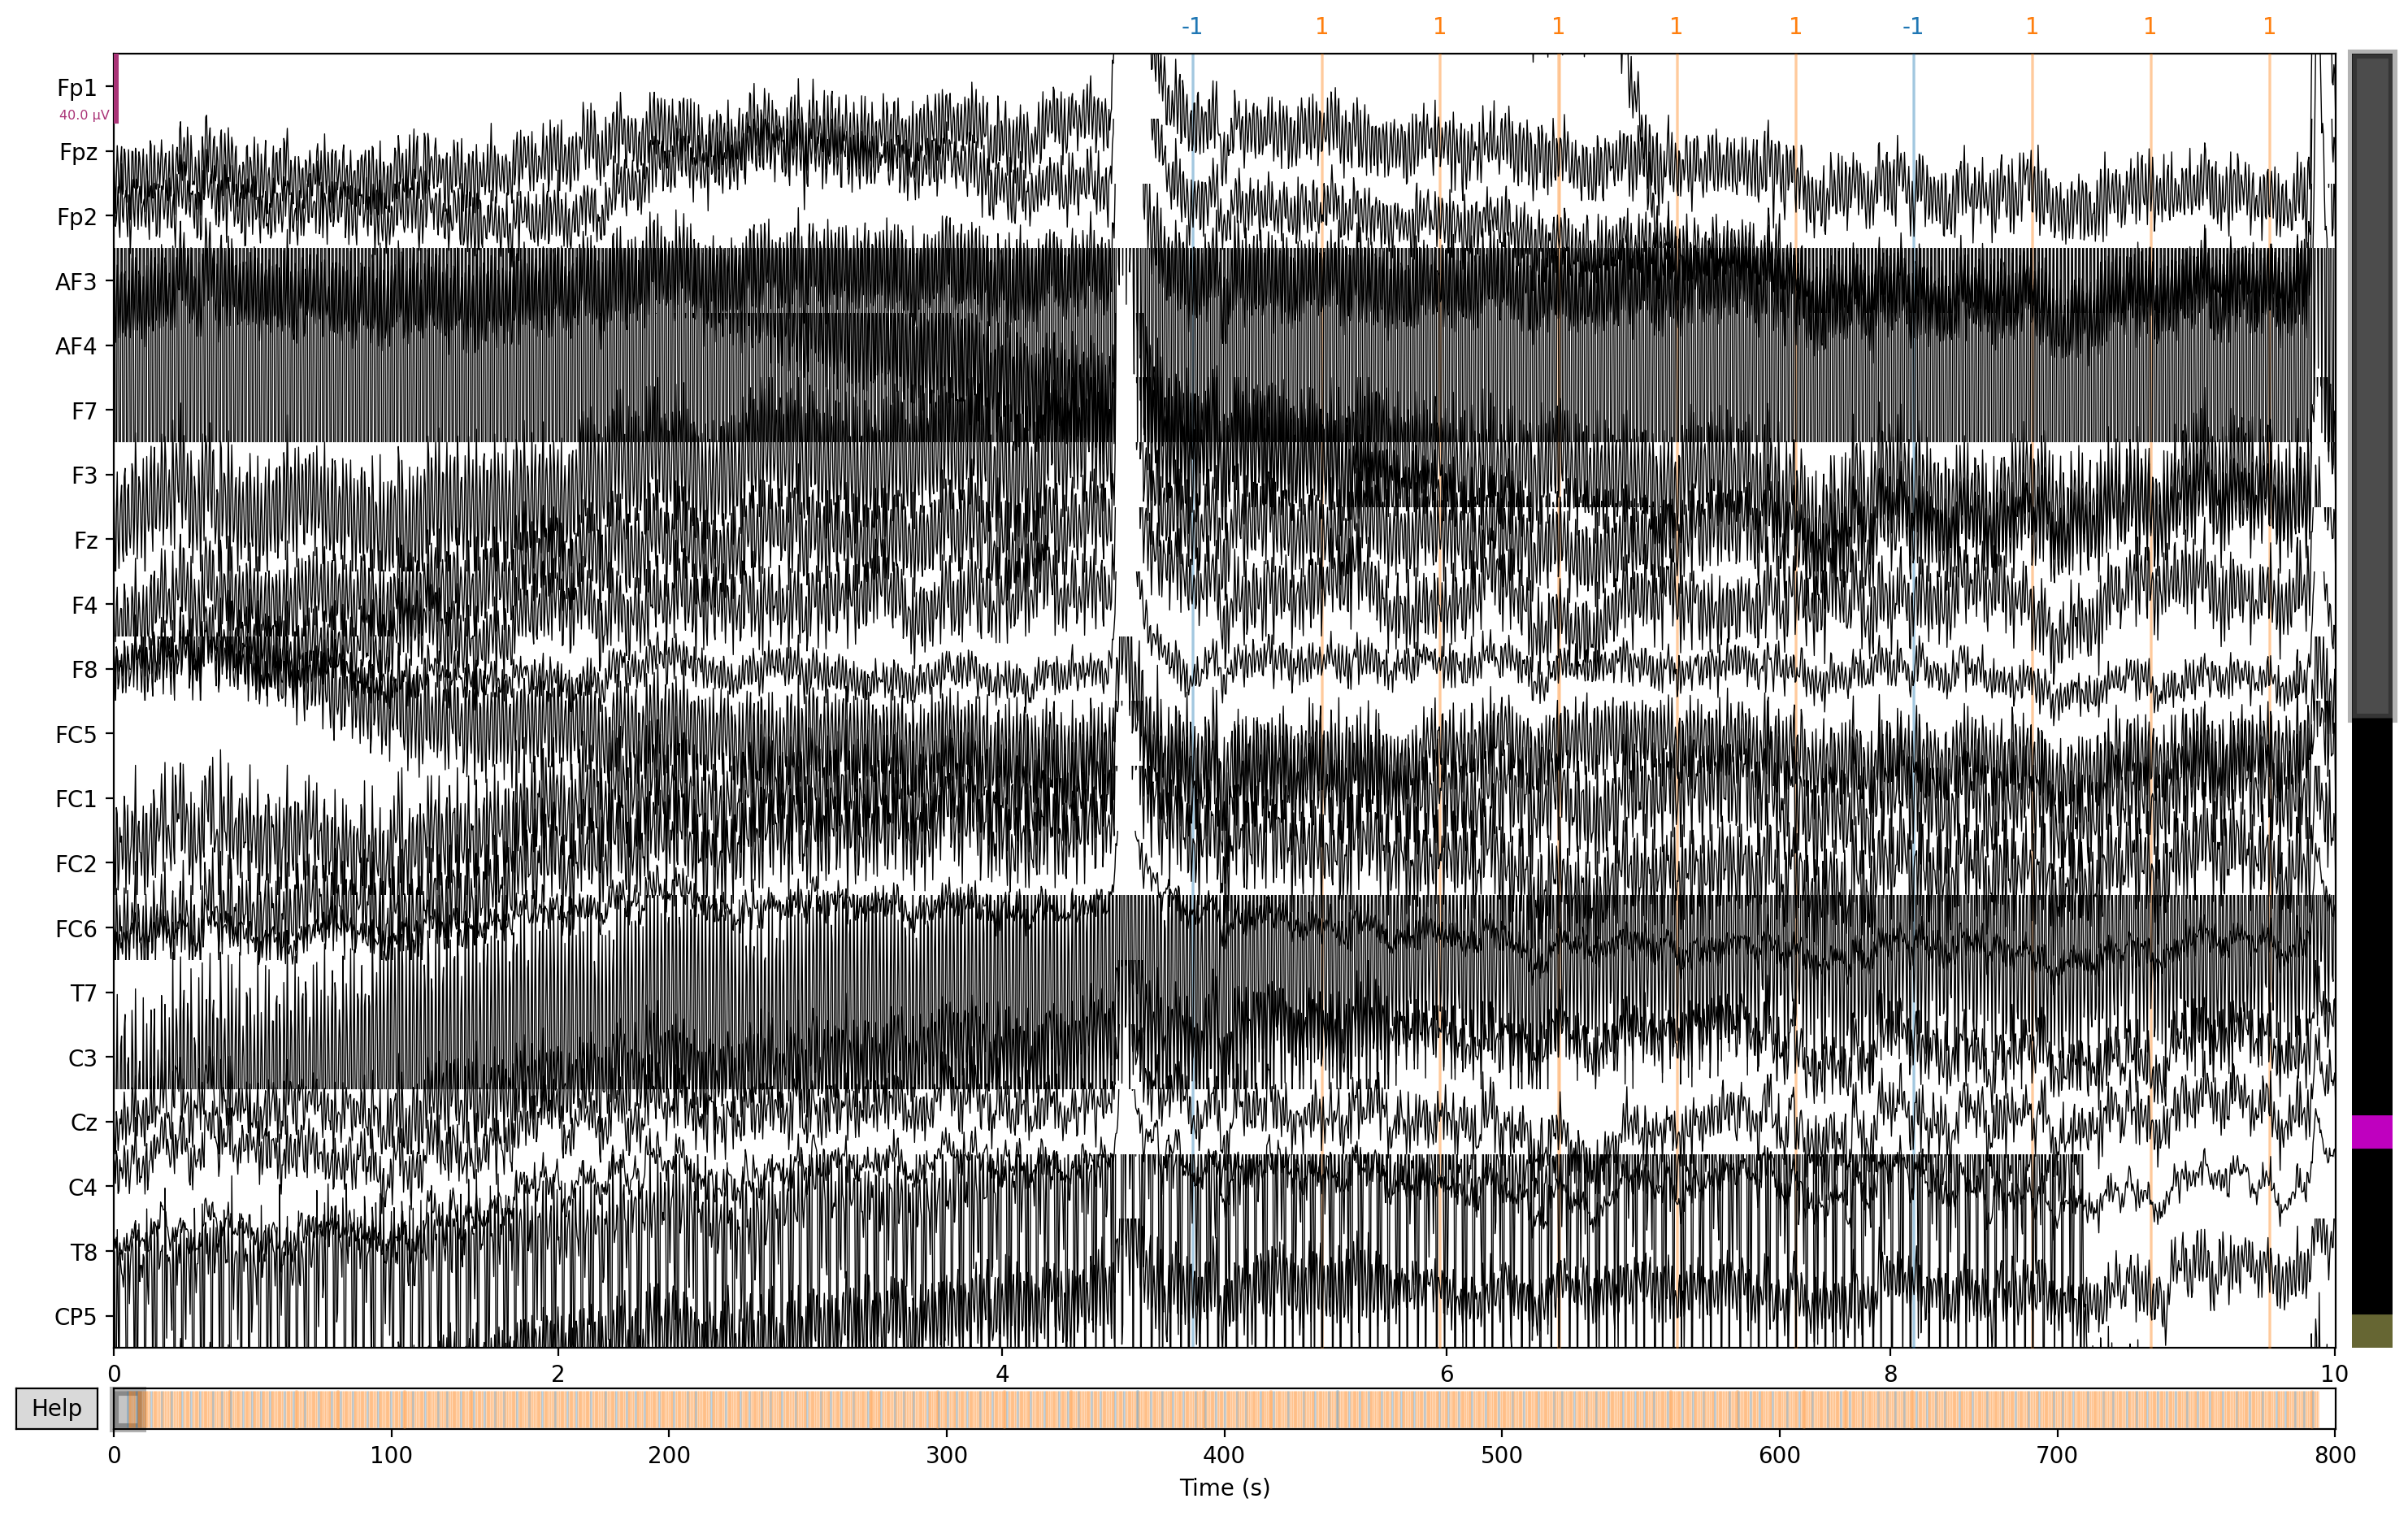

In [18]:
raw = mne.io.read_raw(paths[1])
raw.plot()

Using matplotlib as 2D backend.


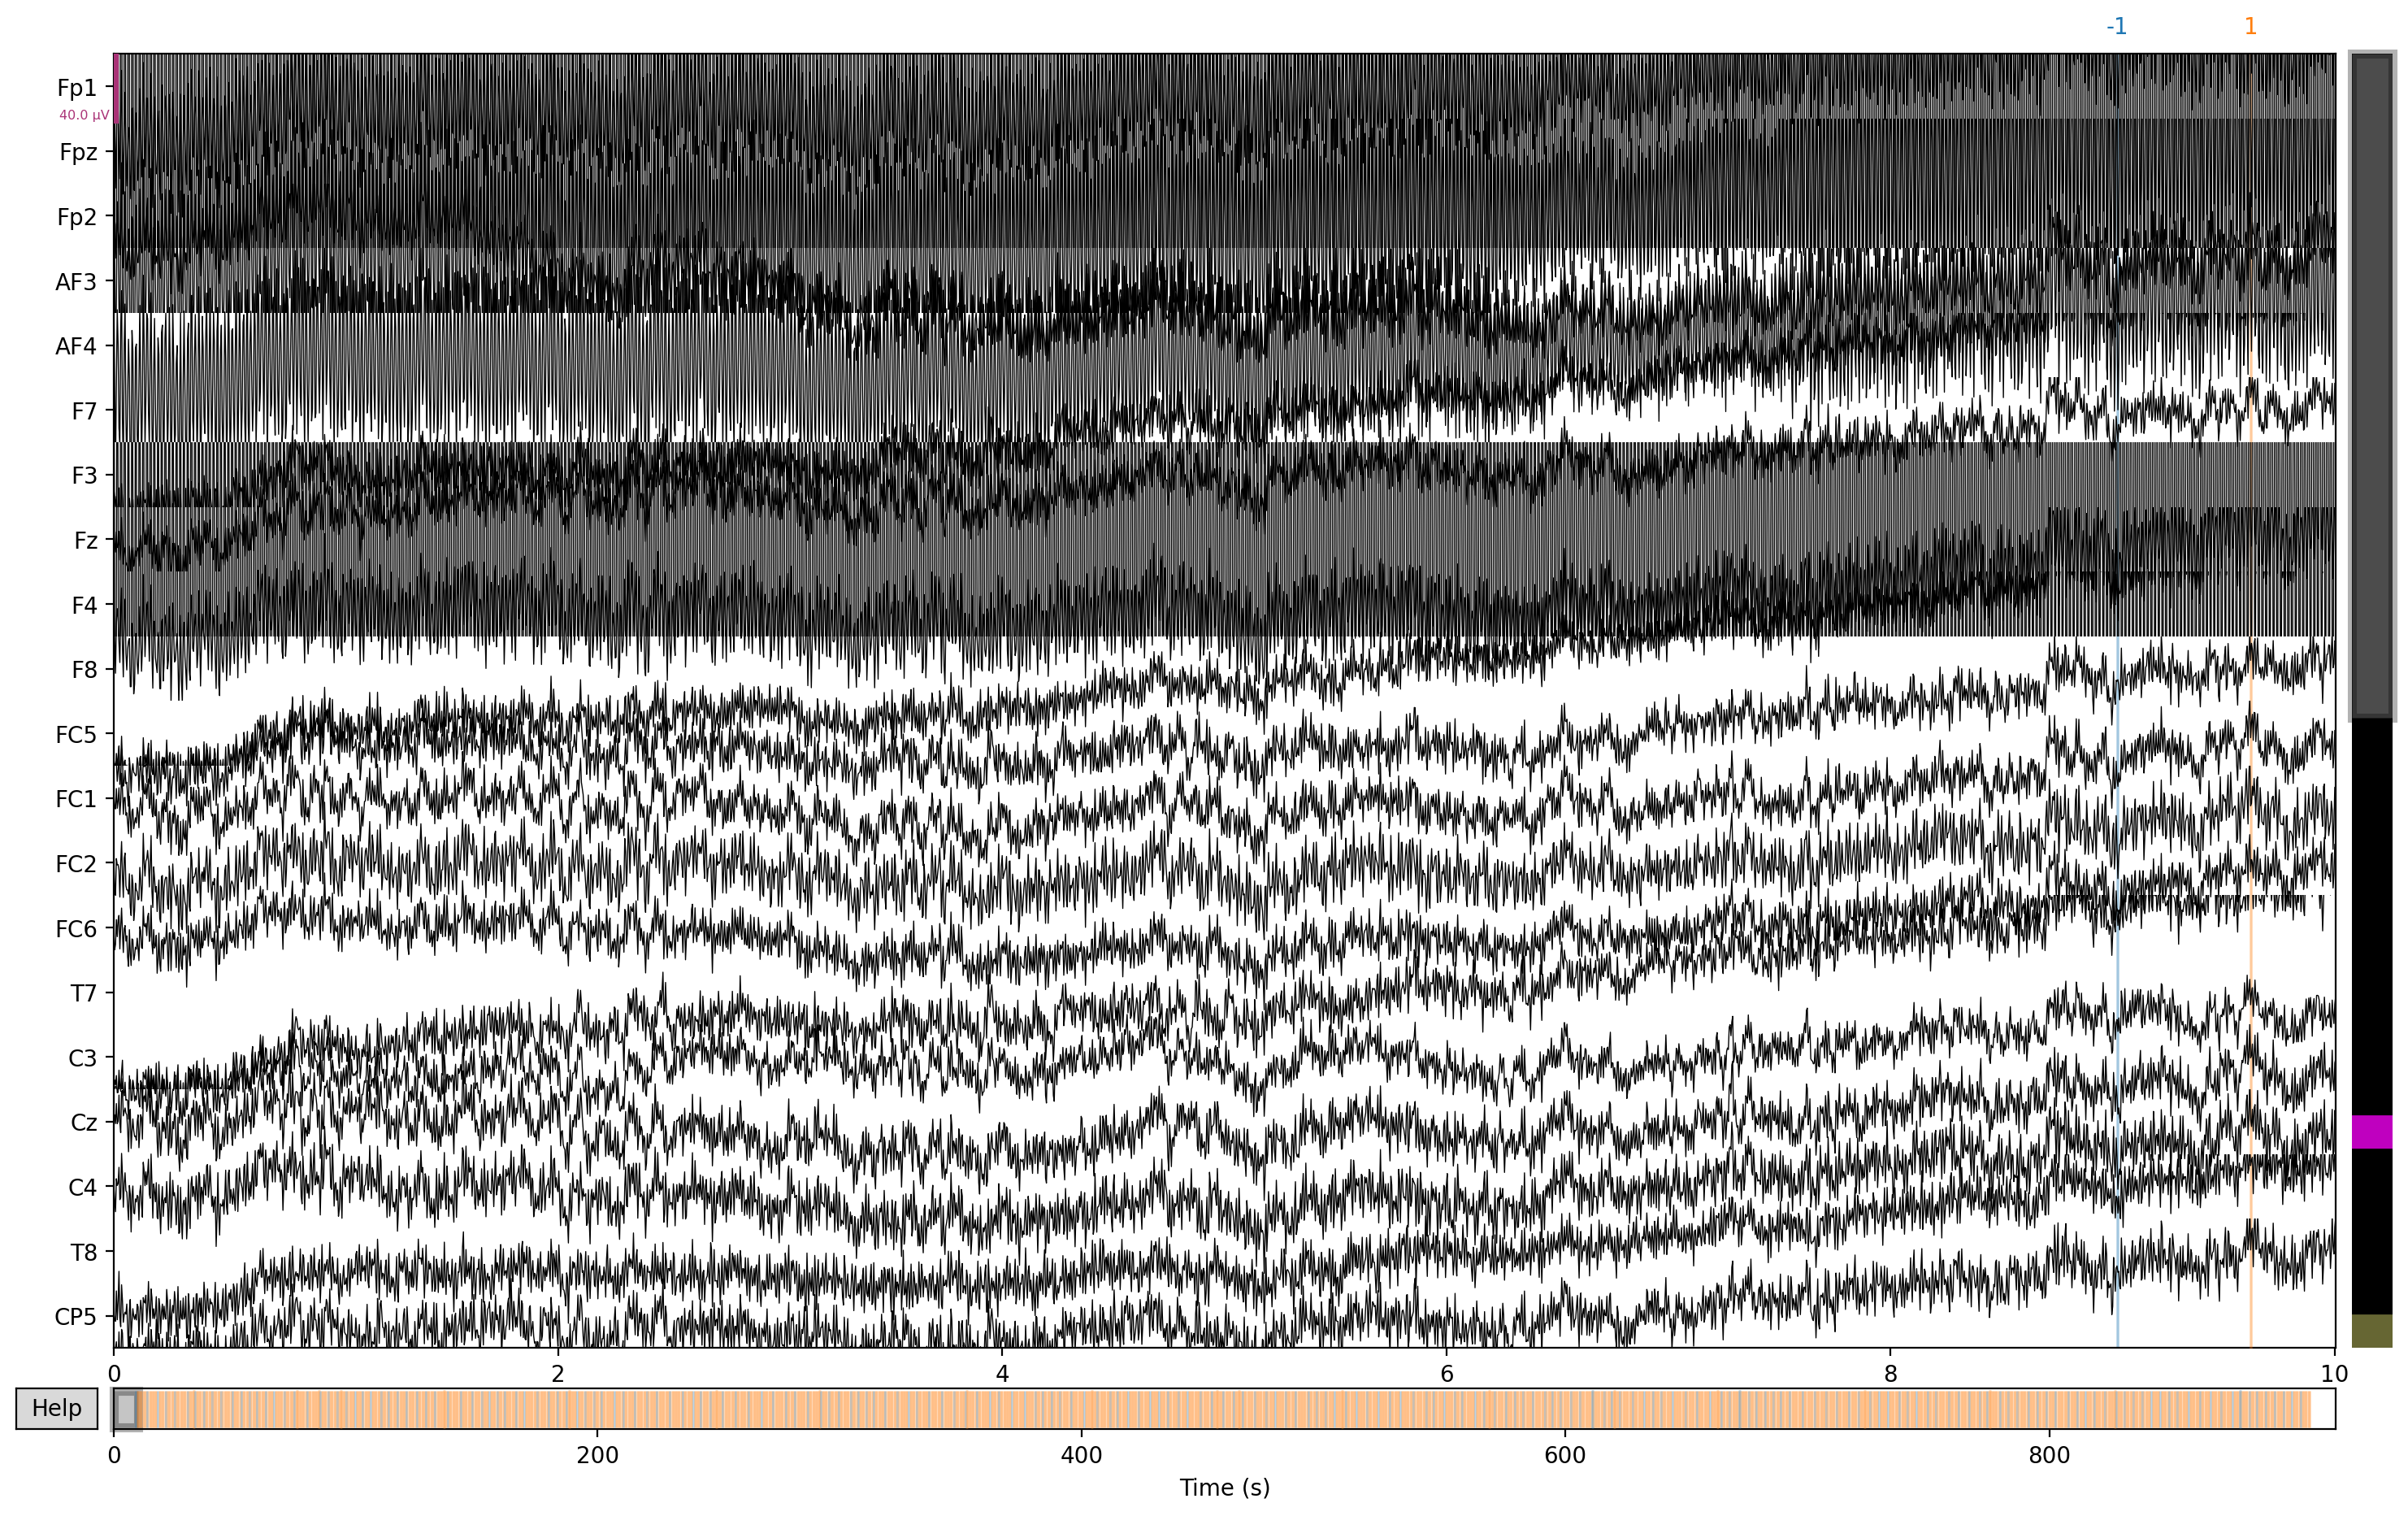

In [17]:
raw.plot()